In [1]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
batch_size = 1
num_batches = 500

In [3]:
# Define a feedforward NN representing the sensory-motor system

input_vis = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_aud')
input_total = tf.concat([input_vis, input_aud], axis = -1)

num_hidden_sensorymotor = 10
hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
num_out_sensorymotor = 2
out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)

In [4]:
# Just train the sensory-motor system to ignore audition
run_sensorymotor_test = False

if run_sensorymotor_test:
    loss = tf.reduce_mean(tf.norm(out_sensorymotor-input_vis))
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op=optimizer.minimize(loss)
    
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    
    num_inputs = batch_size*num_batches
    
    in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)] 
    in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,2])
    
    in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)]
    in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,2])

    losses = []
    for i in range(num_batches):
        in_vis_list_batch = in_vis_list[i]
        in_aud_list_batch = in_aud_list[i]
        l, it, os, _ =  sess.run([loss, input_total, out_sensorymotor, train_op], feed_dict = {input_vis:in_vis_list_batch, input_aud:in_aud_list_batch})
        losses.append(l)
        
    plt.figure()
    plt.plot(losses)
    plt.title("Loss function versus number of batches")
    plt.show()

In [5]:
# Define a feedforward NN representing the sensory-motor system with an ancillary rule label input

input_vis = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_aud')
input_cue = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name = 'input_cue')
input_total = tf.concat([input_vis, input_aud, input_cue], axis = -1)

num_hidden_sensorymotor = 10
hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
num_out_sensorymotor = 2
out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)

In [6]:
# Train the sensory-motor system to follow the given rule
run_sensorymotor_rule_test = False

if run_sensorymotor_rule_test:    
    
    num_inputs = batch_size*num_batches
    
    in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)] 
    in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,2])
    
    in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)]
    in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,2])
    
    cue_list_unshaped = [[np.random.rand()] for k in range(num_inputs)]
    in_cue_list = np.reshape(cue_list_unshaped, [num_batches,batch_size,1])
                
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    sess = tf.Session()
    
    losses = []
    for i in range(num_batches):
        in_vis_list_batch = in_vis_list[i]
        in_aud_list_batch = in_aud_list[i]
        in_cue_list_batch = in_cue_list[i]
        
        loss = 0
        for j in range(batch_size):
            if in_cue_list_batch[j] > 0.5:
                loss += tf.norm(tf.gather(out_sensorymotor-input_vis, [j]))
            else:
                loss += tf.norm(tf.gather(out_sensorymotor-input_aud, [j]))
        
        train_op=optimizer.minimize(loss)
        
        sess.run(tf.initialize_all_variables())
        l, it, os, _ =  sess.run([loss, input_total, out_sensorymotor, train_op], feed_dict = {input_vis:in_vis_list_batch, input_aud:in_aud_list_batch, input_cue:in_cue_list_batch})
        losses.append(l)
        print l
        
    plt.figure()
    plt.plot(losses)
    plt.title("Loss function versus number of batches")
    plt.show()

In [7]:
# Now we will create a mapping from cues to rules
# The rule associated with each cue will change with time and a RNN will have to learn and remember the recent mapping
# while not hanging onto it too long as the mapping changes

# Define an RNN representing the PFC

if False: # Do we run this block

    num_units_PFC = 5

    PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC)
    PFC_state_previous = PFC_cell.zero_state(batch_size, tf.float32) # Initial state of PFC

    # This does one cycle of the RNN
    def PFC_step(input_data, network_state):
        with tf.variable_scope("PFC", reuse=False):
            return PFC_cell(inputs = input_data, state = network_state) 

    # Cue inputs

    num_timesteps = 5
    cue_timeseries = tf.placeholder(shape=[batch_size, num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

    for t in range(num_timesteps):

        current_cue = cue_timeseries[:,t]

        PFC_state = PFC_step(input_data = current_cue, network_state = PFC_state_previous)
        # The output from the PFC into the sensorymotor system will be what we were previously calling the cue variable
        # We'll now call it the rule
        PFC_output = tf.contrib.layers.fully_connected(PFC_state[0], 1, activation_fn = tf.nn.relu)

        PFC_state_previous = PFC_state[1]

    sess = tf.Session()

    ct = np.reshape([np.random.rand() for k in range(num_timesteps * batch_size * num_batches)], [num_batches, batch_size, num_timesteps, 1])

    sess.run(tf.initialize_all_variables())

    for b in range(num_batches):

            ct_in = ct[b, :, :]

            o = sess.run([PFC_output], feed_dict = {cue_timeseries:ct_in})

            print o




499
4.99644
0.0
Tensor("Max_15:0", shape=(), dtype=float32)
output coords, vis in, aud in
[[ 0.41826013  0.43783268]] [[ 0.30305128  0.93209545]] [[ 0.57526901  0.17982869]]
[[ 0.41409284  0.3161929 ]] [[ 0.28171405  0.20799897]] [[ 0.7824582   0.46598949]]
[[ 0.63965774  0.68176883]] [[ 0.83403814  0.58155019]] [[ 0.77127153  0.67334138]]
[[ 0.          0.37530097]] [[ 0.20428011  0.29573129]] [[ 0.40830413  0.61482035]]
[[ 0.56159794  0.96848047]] [[ 0.30706669  0.96791126]] [[ 0.65568051  0.82626044]]
[[ 0.38917169  0.61417329]] [[ 0.01422356  0.80224446]] [[ 0.83016534  0.28567648]]
[[ 0.64889491  0.47526693]] [[ 0.34545872  0.28888051]] [[ 0.81489511  0.52333087]]
[[ 0.36649716  0.30736214]] [[ 0.96292984  0.36276876]] [[ 0.10738509  0.42149449]]
[[ 0.51104438  0.41184163]] [[ 0.44811914  0.77653666]] [[ 0.04258628  0.15291149]]
[[ 0.         0.1611871]] [[ 0.07708906  0.01834716]] [[ 0.78228649  0.91075103]]
[[ 0.19373858  0.        ]] [[ 0.130914  0.509605]] [[ 0.21624839  0.

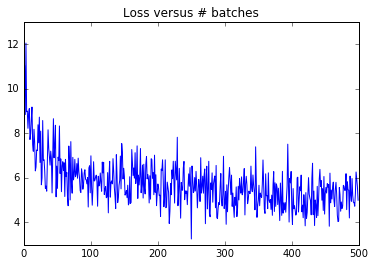

In [8]:
# Now we will create a mapping from cues to rules
# The rule associated with each cue will change with time and a RNN will have to learn and remember the recent mapping
# while not hanging onto it too long as the mapping changes

# Define an RNN representing the PFC

num_units_PFC = 5

PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC)
PFC_state_previous = PFC_cell.zero_state(batch_size, tf.float32) # Initial state of PFC

# This does one cycle of the RNN
def PFC_step(input_data, network_state):
    with tf.variable_scope("PFC", reuse=False):
        return PFC_cell(inputs = input_data, state = network_state) 
    
# Cue inputs

num_timesteps = 15
cue_timeseries = tf.placeholder(shape=[batch_size, num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

input_vis = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_aud')


def rvis():
    return 1.0
def raud():
    return 2.0
def rnull():
    return 0.0

def cue_to_rule_mapping_function(t, integer_input): # Define a changing mapping from cues to rules
    
    if t % 10 < 10: # Always true here but we'll make this change later
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
    else:
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
    return tf.reduce_max([r1,r2,r3,r4])

loss = 0

outs = []

for t in range(num_timesteps):

    current_cue = cue_timeseries[:,t]

    PFC_state = PFC_step(input_data = current_cue, network_state = PFC_state_previous)
    # The output from the PFC into the sensorymotor system will be what we were previously calling the cue variable
    # We'll now call it the rule
    PFC_output = tf.contrib.layers.fully_connected(PFC_state[0], 1, activation_fn = tf.nn.relu)
    
    input_cue_to_sm_sys = PFC_output
    input_total = tf.concat([input_vis[:,t], input_aud[:,t], input_cue_to_sm_sys], axis = -1)
    
    num_hidden_sensorymotor = 10
    hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
    num_out_sensorymotor = 2
    out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)
    
    PFC_state_previous = PFC_state[1]
    
    for e in range(batch_size):
        cc = current_cue[e][0]
        loss_contrib = tf.cond(tf.equal(cue_to_rule_mapping_function(t, cc), tf.constant(1, dtype = tf.float32)), true_fn = lambda: tf.norm(input_vis[e,t] - out_sensorymotor[e]),  false_fn = lambda: tf.norm(input_aud[e,t] - out_sensorymotor[e]))
        loss += loss_contrib

    outs.append(out_sensorymotor)
        
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op=optimizer.minimize(loss)

sess = tf.Session()

# Random cue
ct = np.reshape([np.random.randint(0,4) for k in range(num_timesteps * batch_size * num_batches)], [num_batches, batch_size, num_timesteps, 1])
    
in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)] 
in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,num_timesteps, 2])

in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)]
in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,num_timesteps,2])

sess.run(tf.initialize_all_variables())

losses = []

for b in range(num_batches): # Just testing
        
    ct_in = ct[b, :, :]

    in_v = in_vis_list[b, :, :]

    in_a = in_aud_list[b, :, :]

    os, l, cu, _ = sess.run([outs, loss, cc, train_op], feed_dict = {cue_timeseries:ct_in, input_vis: in_v, input_aud:in_a})
    losses.append(l)
    
print "\n\n"
print b
print l
print cu
print cue_to_rule_mapping_function(num_timesteps-1, cu)
print "output coords, vis in, aud in"
for q in range(num_timesteps):
    print os[:][q], in_v[:,q], in_a[:, q]
#print ct_in
print "correct rule"
print [cue_to_rule_mapping_function(i, float(ct_in[j,i])) for j in range(batch_size) for i in range(num_timesteps)]
        
plt.figure()
plt.plot(losses)
plt.title("Loss versus # batches")
plt.show()